In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats

import statsmodels.formula.api as smf
import lxml

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pd.options.display.float_format = '{:.4f}'.format

In [6]:
def get_data():
    """method to get the data from CSVs"""

    training_data = pd.read_csv("../raw_data/dreaddit-train.csv")
    test_data = pd.read_csv("../raw_data/dreaddit-test.csv")

    #print('success')

    return training_data, test_data

In [7]:
def clean_data(df):
    cols_to_remove = ['syntax_ari',
                   'syntax_fk_grade',
                   'lex_dal_max_pleasantness',
                   'lex_dal_max_activation',
                   'lex_dal_max_imagery',
                   'lex_dal_min_pleasantness',
                   'lex_dal_min_activation',
                   'lex_dal_min_imagery',
                   'lex_dal_avg_activation',
                   'lex_dal_avg_imagery',
                   'lex_dal_avg_pleasantness',
                   'sentiment',
                   'post_id',
                   'social_timestamp',
                   'subreddit',
                   'sentence_range']
    df.drop(columns=cols_to_remove, inplace=True)
    
    rows_to_remove = df['text'].loc[df['text'].apply(lambda x: len(x)<35)].index.to_list()
    
    df.drop(labels=rows_to_remove, inplace=True)
    
    df['pct_caps'] = df['text'].apply(lambda x: sum([char.isupper() for char in x])/len(x))
    df['text'] = df['text'].apply(lambda x: x.lower())
    
    df.set_index('id', inplace=True)
    
    df.drop(columns=['text'], inplace=True) #keeping this separate if anything changes and we need the text
    
    #adding the capping on social variables (social_karma, 'social_num_comments', 
    df['social_karma'] = df['social_karma'].apply(lambda x: 200 if x>200 else x)
    df['social_num_comments'] = df['social_num_comments'].apply(lambda x: 100 if x>100 else x)
    
    return df

In [12]:
training_data, test_data =  get_data()

In [15]:
training_data.shape, test_data.shape

((2838, 116), (715, 116))

In [16]:
clean_train = clean_data(training_data)
clean_test = clean_data(test_data)

In [19]:
clean_train.shape, clean_test.shape

((2833, 99), (715, 99))

### Preproc pipeline and feature selection

## Feature Selection

In [20]:
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [21]:
def calc_MI(df_clean):
    
    features = df_clean.drop(columns=['label','confidence'])
    MI = mutual_info_classif(features, df_clean['label'])
    headers = features.columns
    MI_vars = pd.Series(index=headers, data=MI).sort_values(ascending=False)
    MI_vars_selected = MI_vars[MI_vars>0]
    
    df_post_MI  = df_clean[MI_vars_selected.index.to_list()]
    
    return df_post_MI

In [22]:
def calc_vif(df_post_MI):
    vif = pd.DataFrame()
    vif['variables'] = df_post_MI.columns
    vif['VIF'] = [variance_inflation_factor(df_post_MI, i) for i in range(df_post_MI.shape[1])]
    
    VIF_df = vif[vif['VIF']<30].reset_index(drop=True)
    
    return VIF_df['variables'].to_list()

In [23]:
selected_features = calc_vif(calc_MI(clean_train))

In [25]:
preproc_pipe = Pipeline([
    ('feature_selector', ColumnTransformer([
        ('feature_selector', 'passthrough', selected_features)
    ], remainder='drop')),
    
    ('scaling', MinMaxScaler())
])

In [26]:
X_train = preproc_pipe.fit_transform(clean_train)

In [27]:
X_test = preproc_pipe.transform(clean_test)

In [34]:
df_X_train_scaled = pd.DataFrame(columns = selected_features,
                                 index = clean_train.index,
                                 data = X_train)
df_X_train_scaled.head(3)

,lex_liwc_Tone,lex_liwc_anx,lex_liwc_anger,lex_liwc_Apostro,social_num_comments,lex_liwc_risk,lex_liwc_sad,lex_liwc_affiliation,lex_liwc_OtherP,lex_liwc_focuspast,lex_liwc_feel,lex_liwc_number,lex_liwc_article,social_karma,lex_liwc_Sixltr,lex_liwc_adj,lex_liwc_insight,lex_liwc_sexual,lex_liwc_leisure,lex_liwc_body,lex_liwc_adverb,lex_liwc_cause,lex_liwc_interrog,lex_liwc_swear,lex_liwc_power,lex_liwc_hear,lex_liwc_differ,lex_liwc_SemiC,lex_liwc_friend,lex_liwc_Colon,lex_liwc_tentat,lex_liwc_health,lex_liwc_ingest,lex_liwc_motion,lex_liwc_Period,lex_liwc_informal,lex_liwc_negate,lex_liwc_assent,lex_liwc_WPS,lex_liwc_see,lex_liwc_work,lex_liwc_reward,lex_liwc_conj,lex_liwc_certain,lex_liwc_discrep,lex_liwc_QMark,lex_liwc_money,lex_liwc_relig,lex_liwc_Comma,lex_liwc_Exclam
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
33181,0.000000,0.0344,0.164028,0.0688,0.01,0.1036,0.276,0.000000,0.000000,0.163754,0.123297,0.0688,0.222151,0.025,0.198557,0.331683,0.260574,0.0,0.000000,0.040739,0.241251,0.0688,0.048152,0.103241,0.323331,0.182397,0.140608,0.081671,0.000000,0.055917,0.310138,0.131198,0.0,0.059107,0.201445,0.065951,0.133333,0.0,0.115351,0.158234,0.046688,0.113907,0.208313,0.0000,0.2072,0.000000,0.000000,0.31432,0.082418,0.0
2606,0.991633,0.0000,0.000000,0.1100,0.02,0.0000,0.000,0.238302,0.009366,0.034954,0.000000,0.1100,0.531874,0.020,0.324017,0.151265,0.138218,0.0,0.000000,0.000000,0.171255,0.0000,0.051512,0.000000,0.550638,0.000000,0.348534,0.000000,0.000000,0.000000,0.329934,0.000000,0.0,0.189003,0.097535,0.140337,0.071318,0.0,0.107762,0.084637,0.597720,0.364238,0.399227,0.1543,0.2936,0.000000,0.061621,0.00000,0.065695,0.0
38816,0.252755,0.0000,0.000000,0.0720,0.00,0.0000,0.000,0.233536,0.000000,0.136398,0.000000,0.0480,0.347070,0.010,0.266738,0.066007,0.316465,0.0,0.090023,0.028423,0.083994,0.0960,0.033595,0.000000,0.090023,0.000000,0.097720,0.000000,0.349222,0.000000,0.179364,0.000000,0.0,0.329210,0.050999,0.000000,0.093023,0.0,0.134432,0.000000,0.000000,0.317881,0.289512,0.0000,0.0480,0.005692,0.000000,0.00000,0.085762,0.0


In [40]:
df_X_test_scaled = pd.DataFrame(columns = selected_features,
                                index = clean_test.index,
                                data = X_test)
df_X_test_scaled.head(3)

,lex_liwc_Tone,lex_liwc_anx,lex_liwc_anger,lex_liwc_Apostro,social_num_comments,lex_liwc_risk,lex_liwc_sad,lex_liwc_affiliation,lex_liwc_OtherP,lex_liwc_focuspast,lex_liwc_feel,lex_liwc_number,lex_liwc_article,social_karma,lex_liwc_Sixltr,lex_liwc_adj,lex_liwc_insight,lex_liwc_sexual,lex_liwc_leisure,lex_liwc_body,lex_liwc_adverb,lex_liwc_cause,lex_liwc_interrog,lex_liwc_swear,lex_liwc_power,lex_liwc_hear,lex_liwc_differ,lex_liwc_SemiC,lex_liwc_friend,lex_liwc_Colon,lex_liwc_tentat,lex_liwc_health,lex_liwc_ingest,lex_liwc_motion,lex_liwc_Period,lex_liwc_informal,lex_liwc_negate,lex_liwc_assent,lex_liwc_WPS,lex_liwc_see,lex_liwc_work,lex_liwc_reward,lex_liwc_conj,lex_liwc_certain,lex_liwc_discrep,lex_liwc_QMark,lex_liwc_money,lex_liwc_relig,lex_liwc_Comma,lex_liwc_Exclam
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
896,0.050510,0.0000,0.0,0.0728,0.62,0.0728,0.000,0.157712,0.000000,0.207067,0.0,0.2180,0.000000,0.110,0.111640,0.100110,0.000000,0.0,0.0,0.0,0.084928,0.0000,0.101904,0.0,0.136534,0.0,0.789902,0.0,0.177043,0.118336,0.436113,0.00000,0.0,0.000000,0.270506,0.000000,0.563566,0.000000,0.037294,0.000000,0.000000,0.241060,0.703238,0.000000,0.5816,0.0,0.000000,0.0,0.130196,0.0
19059,0.932653,0.0000,0.0,0.0000,0.02,0.0000,0.000,0.120451,0.010642,0.052812,0.0,0.1112,0.358017,0.025,0.383907,0.076458,0.314955,0.0,0.0,0.0,0.259449,0.1112,0.155655,0.0,0.208552,0.0,0.075461,0.0,0.000000,0.000000,0.166767,0.00000,0.0,0.095533,0.147471,0.000000,0.000000,0.000000,0.052038,0.000000,1.206298,0.552318,0.402610,0.000000,0.1112,0.0,0.279303,0.0,0.099618,0.0
7977,0.154592,0.0272,0.0,0.0540,0.08,0.0000,0.108,0.116984,0.000000,0.231003,0.0,0.0540,0.173857,0.050,0.166001,0.260176,0.153323,0.0,0.0,0.0,0.283714,0.0000,0.038074,0.0,0.101275,0.0,0.219870,0.0,0.066148,0.000000,0.202759,0.20595,0.0,0.139519,0.344666,0.207055,0.052713,0.078161,0.081266,0.062557,0.036916,0.178808,0.457226,0.057336,0.2704,0.0,0.135968,0.0,0.000000,0.0


In [41]:
df_X_train_scaled.shape, df_X_test_scaled.shape, len(selected_features)

((2833, 50), (715, 50), 50)

In [46]:
#Train and test data set 

y_train = clean_train['label']

y_test = clean_test['label']

### Merging train and test data for visual analysis

In [58]:
X = pd.concat([df_X_train_scaled,df_X_test_scaled])
y = pd.concat([y_train,y_test])
smf_data = pd.concat([X,y], axis=1)

In [59]:
smf_log_reg_results = smf.ols(formula = 'label' + " ~ " +  " + ".join(smf_data.columns[:-1]), data=smf_data).fit().summary()

In [63]:
smf_log_reg_results.tables[0]

Dep. Variable:,label,R-squared:,0.322
Model:,OLS,Adj. R-squared:,0.312
Method:,Least Squares,F-statistic:,33.17
Date:,"Tue, 08 Mar 2022",Prob (F-statistic):,3.48e-253
Time:,19:30:08,Log-Likelihood:,-1882.8
No. Observations:,3548,AIC:,3868.
Df Residuals:,3497,BIC:,4182.
Df Model:,50,,
Covariance Type:,nonrobust,,


In [64]:
smf_log_reg_results.tables[2]

Omnibus:,418.613,Durbin-Watson:,1.973
Prob(Omnibus):,0.000,Jarque-Bera (JB):,120.148
Skew:,-0.123,Prob(JB):,8.13e-27
Kurtosis:,2.133,Cond. No.,74.4


In [65]:
results_as_html = smf_log_reg_results.tables[1].as_html()
smf_results = pd.read_html(results_as_html, header=0, index_col=0)[0]
smf_results = smf_results[smf_results['P>|t|']<0.05].sort_values(by='P>|t|')
smf_results

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7064,0.066,10.638,0.000,0.576,0.837
lex_liwc_see,-0.3271,0.070,-4.682,0.000,-0.464,-0.190
lex_liwc_negate,0.3266,0.063,5.184,0.000,0.203,0.450
lex_liwc_ingest,-0.7485,0.194,-3.849,0.000,-1.130,-0.367
lex_liwc_differ,-0.2566,0.067,-3.855,0.000,-0.387,-0.126
lex_liwc_swear,0.4720,0.121,3.892,0.000,0.234,0.710
social_karma,-0.2783,0.063,-4.426,0.000,-0.402,-0.155
lex_liwc_article,-0.1994,0.046,-4.322,0.000,-0.290,-0.109
lex_liwc_feel,0.4773,0.082,5.801,0.000,0.316,0.639
lex_liwc_Sixltr,-0.3590,0.097,-3.717,0.000,-0.548,-0.170


In [67]:
sign_feat_list = smf_results[smf_results['P>|t|']<0.05].sort_values(by='P>|t|').index
len(sign_feat_list[1:]) #exclude the intercept

29

In [68]:
sign_feat_list[1:]

Index(['lex_liwc_see', 'lex_liwc_negate', 'lex_liwc_ingest', 'lex_liwc_differ',
       'lex_liwc_swear', 'social_karma', 'lex_liwc_article', 'lex_liwc_feel',
       'lex_liwc_Sixltr', 'lex_liwc_Comma', 'lex_liwc_Tone',
       'lex_liwc_focuspast', 'lex_liwc_anx', 'lex_liwc_health',
       'lex_liwc_risk', 'lex_liwc_affiliation', 'lex_liwc_WPS', 'lex_liwc_sad',
       'lex_liwc_adverb', 'lex_liwc_conj', 'lex_liwc_QMark',
       'lex_liwc_Apostro', 'lex_liwc_Colon', 'lex_liwc_number',
       'lex_liwc_anger', 'lex_liwc_OtherP', 'lex_liwc_informal',
       'lex_liwc_discrep', 'lex_liwc_hear'],
      dtype='object')

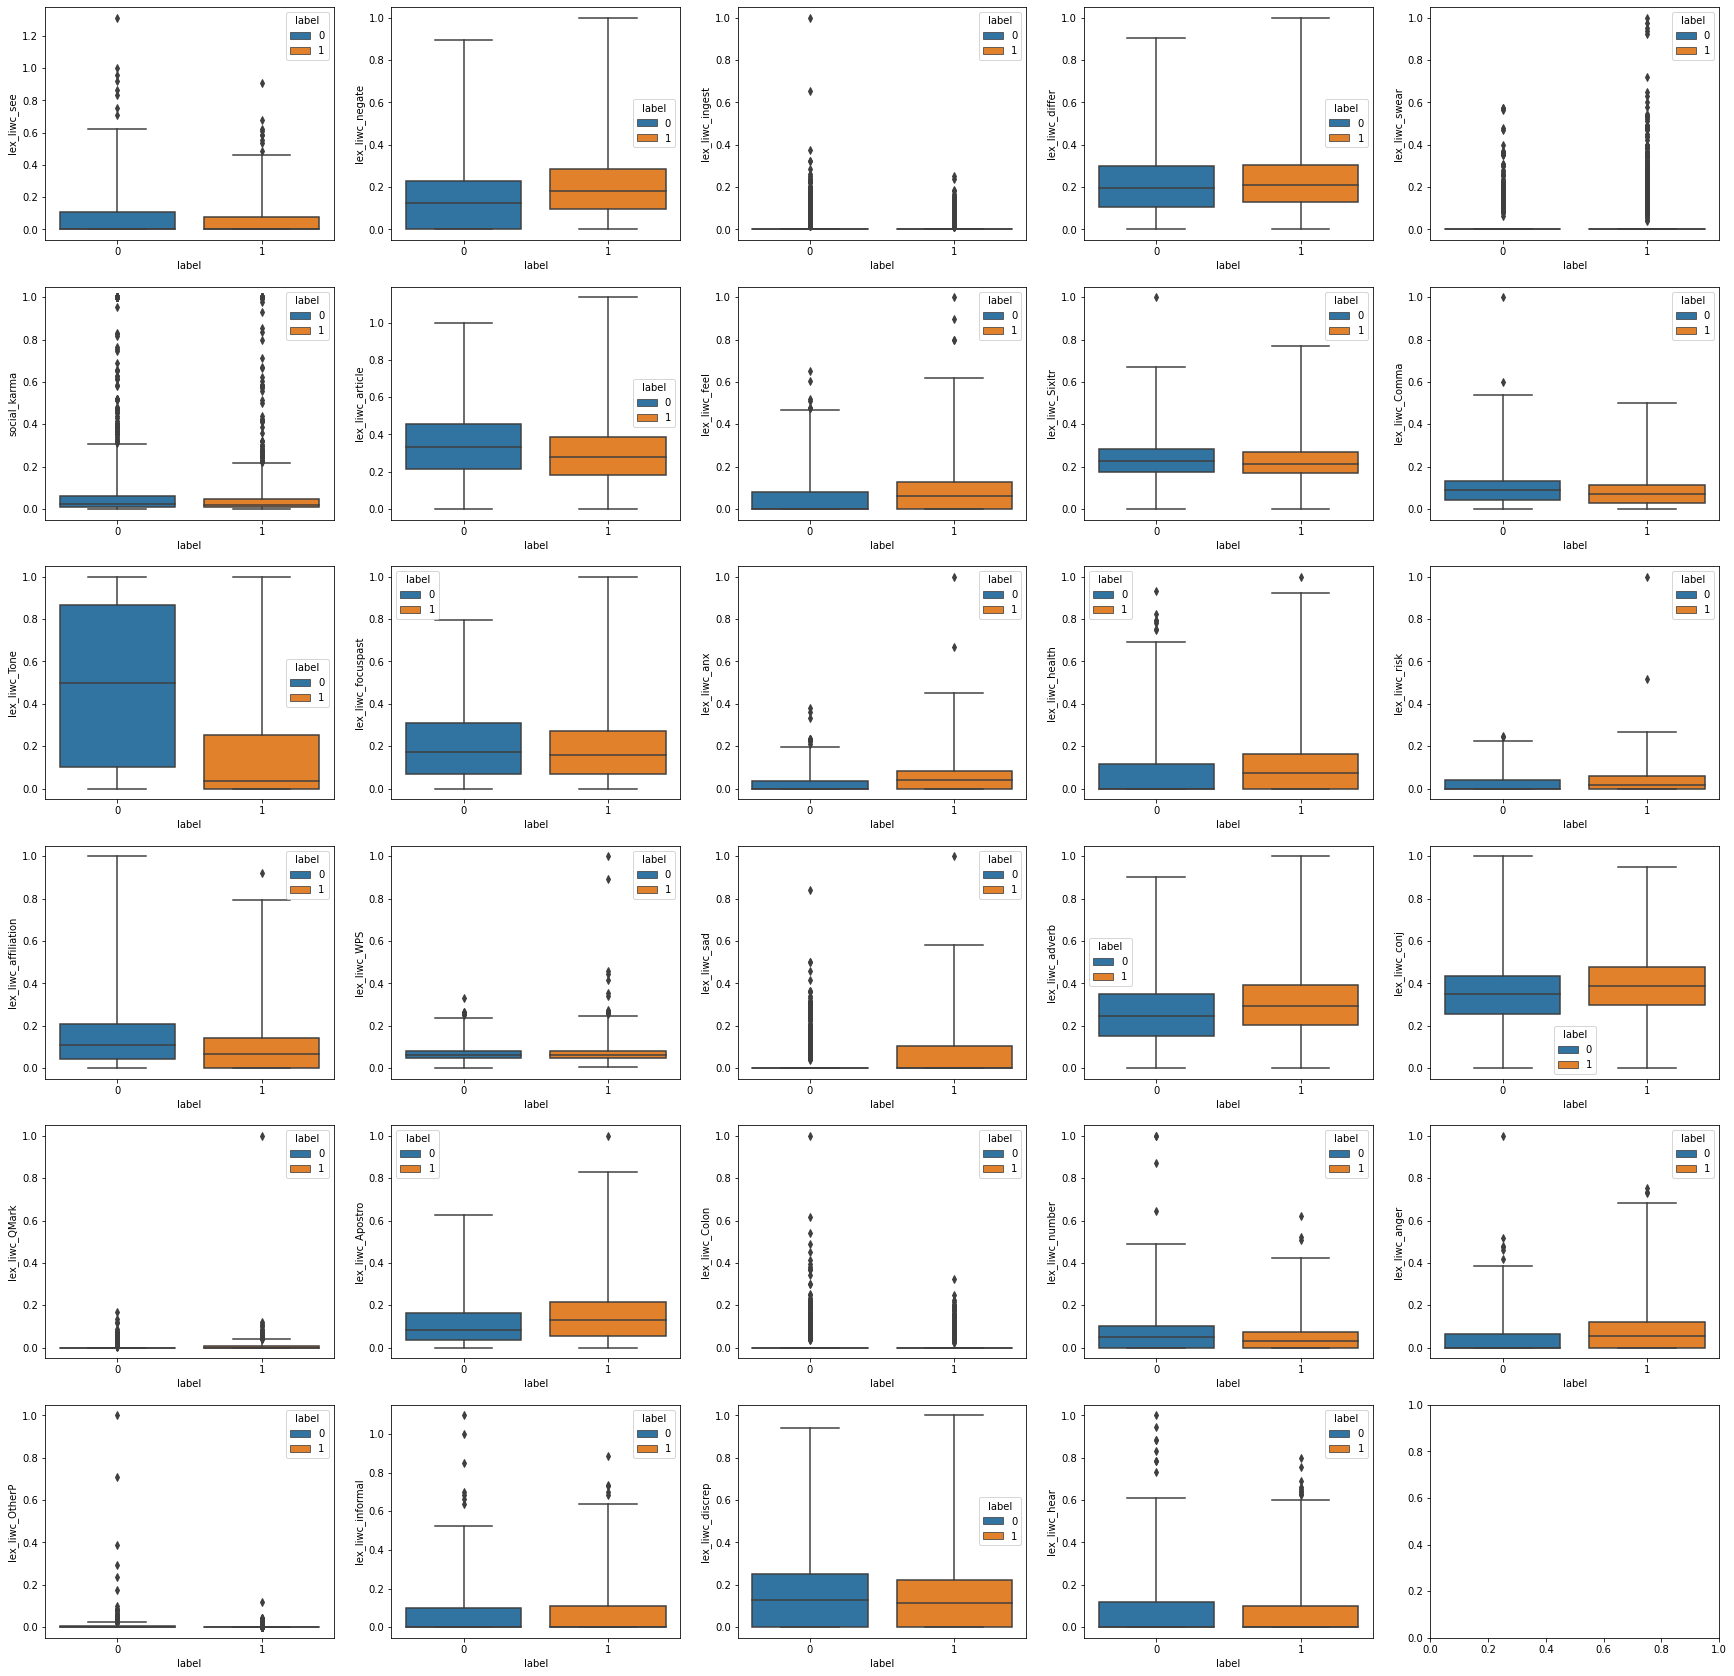

In [70]:
fig, axs = plt.subplots(nrows=6,ncols=5,figsize=(30,30) )
#pal = sns.color_palette(palette=None, n_colors=len(sign_feat_list[1:]))

for (i,f) in zip(axs.flatten(),sign_feat_list[1:]):
    sns.boxplot(ax=i, hue=smf_data['label'], x=smf_data['label'], y=smf_data[f], whis=5, dodge=False )

In [73]:
smf_data.head()

,lex_liwc_Tone,lex_liwc_anx,lex_liwc_anger,lex_liwc_Apostro,social_num_comments,lex_liwc_risk,lex_liwc_sad,lex_liwc_affiliation,lex_liwc_OtherP,lex_liwc_focuspast,lex_liwc_feel,lex_liwc_number,lex_liwc_article,social_karma,lex_liwc_Sixltr,lex_liwc_adj,lex_liwc_insight,lex_liwc_sexual,lex_liwc_leisure,lex_liwc_body,lex_liwc_adverb,lex_liwc_cause,lex_liwc_interrog,lex_liwc_swear,lex_liwc_power,lex_liwc_hear,lex_liwc_differ,lex_liwc_SemiC,lex_liwc_friend,lex_liwc_Colon,lex_liwc_tentat,lex_liwc_health,lex_liwc_ingest,lex_liwc_motion,lex_liwc_Period,lex_liwc_informal,lex_liwc_negate,lex_liwc_assent,lex_liwc_WPS,lex_liwc_see,lex_liwc_work,lex_liwc_reward,lex_liwc_conj,lex_liwc_certain,lex_liwc_discrep,lex_liwc_QMark,lex_liwc_money,lex_liwc_relig,lex_liwc_Comma,lex_liwc_Exclam,label
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
33181,0.000000,0.0344,0.164028,0.0688,0.01,0.1036,0.2760,0.000000,0.000000,0.163754,0.123297,0.0688,0.222151,0.025,0.198557,0.331683,0.260574,0.000000,0.000000,0.040739,0.241251,0.0688,0.048152,0.103241,0.323331,0.182397,0.140608,0.081671,0.000000,0.055917,0.310138,0.131198,0.000000,0.059107,0.201445,0.065951,0.133333,0.000000,0.115351,0.158234,0.046688,0.113907,0.208313,0.000000,0.2072,0.000000,0.000000,0.31432,0.082418,0.0,1
2606,0.991633,0.0000,0.000000,0.1100,0.02,0.0000,0.0000,0.238302,0.009366,0.034954,0.000000,0.1100,0.531874,0.020,0.324017,0.151265,0.138218,0.000000,0.000000,0.000000,0.171255,0.0000,0.051512,0.000000,0.550638,0.000000,0.348534,0.000000,0.000000,0.000000,0.329934,0.000000,0.000000,0.189003,0.097535,0.140337,0.071318,0.000000,0.107762,0.084637,0.597720,0.364238,0.399227,0.154300,0.2936,0.000000,0.061621,0.00000,0.065695,0.0,0
38816,0.252755,0.0000,0.000000,0.0720,0.00,0.0000,0.0000,0.233536,0.000000,0.136398,0.000000,0.0480,0.347070,0.010,0.266738,0.066007,0.316465,0.000000,0.090023,0.028423,0.083994,0.0960,0.033595,0.000000,0.090023,0.000000,0.097720,0.000000,0.349222,0.000000,0.179364,0.000000,0.000000,0.329210,0.050999,0.000000,0.093023,0.000000,0.134432,0.000000,0.000000,0.317881,0.289512,0.000000,0.0480,0.005692,0.000000,0.00000,0.085762,0.0,1
239,0.798571,0.0000,0.023433,0.0000,0.05,0.0292,0.0584,0.174610,0.000000,0.292173,0.393548,0.0000,0.212492,0.000,0.123771,0.201320,0.580816,0.050409,0.027757,0.000000,0.307513,0.0584,0.061590,0.000000,0.054764,0.000000,0.258415,0.000000,0.107004,0.000000,0.109778,0.000000,0.011101,0.125773,0.054399,0.196319,0.283721,0.083908,0.226366,0.101196,0.039631,0.145695,0.478009,0.123946,0.1464,0.000000,0.000000,0.00000,0.175108,0.0,1
1421,0.000000,0.0448,0.284357,0.0448,0.01,0.0448,0.0000,0.000000,0.000000,0.213526,0.161290,0.0448,0.289118,0.120,0.483108,0.246975,0.254532,0.152589,0.000000,0.000000,0.209519,0.1800,0.062710,0.000000,0.336834,0.000000,0.243757,0.000000,0.000000,0.072822,0.000000,0.085431,0.000000,0.154639,0.119422,0.085890,0.174419,0.000000,0.066782,0.000000,0.060803,0.000000,0.217013,0.094435,0.0000,0.000000,0.075017,0.00000,0.161013,0.0,1


In [77]:
data = pd.concat([training_data, test_data])

,label,confidence,social_karma,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,lex_liwc_Dic,lex_liwc_function,lex_liwc_pronoun,lex_liwc_ppron,lex_liwc_i,lex_liwc_we,lex_liwc_you,lex_liwc_shehe,lex_liwc_they,lex_liwc_ipron,lex_liwc_article,lex_liwc_prep,lex_liwc_auxverb,lex_liwc_adverb,lex_liwc_conj,lex_liwc_negate,lex_liwc_verb,lex_liwc_adj,lex_liwc_compare,lex_liwc_interrog,lex_liwc_number,lex_liwc_quant,lex_liwc_affect,lex_liwc_posemo,lex_liwc_negemo,lex_liwc_anx,lex_liwc_anger,lex_liwc_sad,lex_liwc_social,lex_liwc_family,lex_liwc_friend,lex_liwc_female,lex_liwc_male,lex_liwc_cogproc,lex_liwc_insight,lex_liwc_cause,lex_liwc_discrep,lex_liwc_tentat,lex_liwc_certain,lex_liwc_differ,lex_liwc_percept,lex_liwc_see,lex_liwc_hear,lex_liwc_feel,lex_liwc_bio,lex_liwc_body,lex_liwc_health,lex_liwc_sexual,lex_liwc_ingest,lex_liwc_drives,lex_liwc_affiliation,lex_liwc_achieve,lex_liwc_power,lex_liwc_reward,lex_liwc_risk,lex_liwc_focuspast,lex_liwc_focuspresent,lex_liwc_focusfuture,lex_liwc_relativ,lex_liwc_motion,lex_liwc_space,lex_liwc_time,lex_liwc_work,lex_liwc_leisure,lex_liwc_home,lex_liwc_money,lex_liwc_relig,lex_liwc_death,lex_liwc_informal,lex_liwc_swear,lex_liwc_netspeak,lex_liwc_assent,lex_liwc_nonflu,lex_liwc_filler,lex_liwc_AllPunc,lex_liwc_Period,lex_liwc_Comma,lex_liwc_Colon,lex_liwc_SemiC,lex_liwc_QMark,lex_liwc_Exclam,lex_liwc_Dash,lex_liwc_Quote,lex_liwc_Apostro,lex_liwc_Parenth,lex_liwc_OtherP,social_upvote_ratio,social_num_comments,pct_caps
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
33181,1,0.800000,5,116,72.64,15.04,89.26,1.00,29.00,12.93,87.07,56.03,16.38,12.07,9.48,0.00,0.86,1.72,0.00,4.31,3.45,19.83,7.76,5.17,4.31,1.72,16.38,6.03,3.45,0.86,1.72,1.72,8.62,1.72,6.90,0.86,2.59,3.45,3.45,0.00,0.00,0.00,1.72,11.21,3.45,0.86,2.59,5.17,0.00,2.59,6.03,1.72,1.72,1.72,2.59,0.86,1.72,0.00,0.00,8.62,0.00,1.72,4.31,0.86,2.59,4.31,11.21,0.86,17.24,0.86,10.34,6.03,0.86,0.00,0.00,0.00,2.59,0.00,0.86,0.86,0.00,0.00,0.0,0.0,21.55,9.48,3.45,0.86,0.86,0.00,0.00,0.00,5.17,1.72,0.00,0.00,0.86,1,0.084063
2606,0,1.000000,4,109,79.08,76.85,56.75,98.18,27.25,21.10,87.16,48.62,11.93,7.34,1.83,2.75,2.75,0.00,0.00,4.59,8.26,13.76,6.42,3.67,8.26,0.92,15.60,2.75,0.92,0.92,2.75,0.92,5.50,5.50,0.00,0.00,0.00,0.00,11.01,0.00,0.00,0.00,0.00,11.93,1.83,0.00,3.67,5.50,1.83,6.42,0.92,0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.60,5.50,3.67,7.34,2.75,0.00,0.92,13.76,0.92,15.60,2.75,10.09,1.83,11.01,0.00,0.00,0.92,0.00,0.00,1.83,0.00,0.92,0.00,0.0,0.0,14.68,4.59,2.75,0.00,0.00,0.00,0.00,0.00,0.00,2.75,0.92,3.67,0.65,2,0.037415
38816,1,0.800000,2,167,33.80,76.38,86.24,25.77,33.40,17.37,91.02,61.68,25.15,16.17,8.98,1.80,1.80,2.99,0.60,8.98,5.39,12.57,10.18,1.80,5.99,1.20,20.96,1.20,0.60,0.60,1.20,1.80,2.40,1.20,1.20,0.00,0.00,0.00,15.57,0.60,3.59,1.80,2.40,10.18,4.19,1.20,0.60,2.99,0.00,1.80,0.00,0.00,0.00,0.00,0.60,0.60,0.00,0.00,0.00,8.98,5.39,0.60,1.20,2.40,0.00,3.59,14.37,1.80,16.17,4.79,5.99,5.39,0.00,1.20,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,10.78,2.40,3.59,0.00,0.00,0.60,0.00,0.00,2.40,1.80,0.00,0.00,0.67,0,0.012987
239,1,0.600000,0,273,2.98,15.25,95.42,79.26,54.60,8.06,98.90,65.57,30.40,23.44,16.12,0.37,0.37,6.59,0.00,6.96,3.30,9.16,8.79,6.59,9.89,3.66,20.88,3.66,1.83,1.10,0.00,1.10,8.79,5.86,2.93,0.00,0.37,0.73,13.55,0.37,1.10,0.37,8.06,16.85,7.69,0.73,1.83,1.83,1.47,4.76,7.33,1.10,0.00,5.49,2.20,0.00,0.00,0.37,0.37,6.59,4.03,0.00,0.73,1.10,0.73,7.69,13.19,1.10,10.99,1.83,3.30,6.23,0.73,0.37,0.37,0.00,0.00,0.00,2.56,0.00,0.73,0.73,0.0,0.0,12.09,2.56,7.33,0.00,0.00,0.00,0.00,0.00,1.47,0.00,0.73,0.00,0.50,5,0.009397
1421,1,0.800000,24,89,32.22,28.71,84.01,1.00,17.80,31.46,88.76,52.81,15.73,11.24,7.87,0.00,0.00,3.37,0.00,4.49,4.49,8.99,13.48,4.49,4.49,2.25,13.48,4.49,2.25,1.12,1.12,1.12,7.87,0.00,7.87,1.12,4.49,0.00,8.99,0.00,0.00,0.00,4.49,11.24,3.37,2.25,0.00,0.00,1.12,4.49,2.25,0.00,0.00,2.25,2.25,0.00,1.12,1.12,0.00,7.87

In [78]:
data_train = pd.read_csv('../raw_data/dreaddit-train.csv', parse_dates=True)
data_test = pd.read_csv('../raw_data/dreaddit-test.csv', parse_dates=True)
data = pd.concat([data_train, data_test])

In [85]:
data['domain'] = data['subreddit'].map({'domesticviolence': 'abuse',
                                                   'survivorsofabuse': 'abuse',
                                                   'anxiety': 'anxiety',
                                                   'stress': 'anxiety',
                                                   'almosthomeless': 'ﬁnancial',
                                                   'assistance': 'ﬁnancial',
                                                   'food_pantry': 'ﬁnancial',
                                                   'homeless':'ﬁnancial',
                                                   'ptsd':'ptsd',
                                                   'relationships':'social'
                                                   })


In [86]:
stressed = data.loc[data['label']==1]['text']
non_stressed = data.loc[data['label']==0]['text']
stressed_corpus = " ".join(["".join(i) for i in stressed])
non_stressed_corpus = " ".join(["".join(i) for i in non_stressed])
from wordcloud import WordCloud, STOPWORDS
wordcloud_stressed = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(stressed_corpus)
wordcloud_non_stressed = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(non_stressed_corpus)

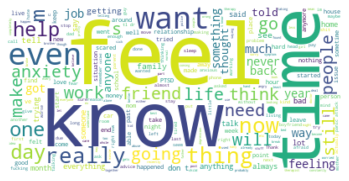

In [140]:
plt.imshow(wordcloud_stressed, interpolation='bilinear')
plt.axis("off")
plt.show()

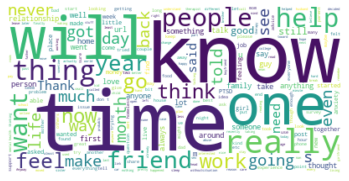

In [142]:
plt.imshow(wordcloud_non_stressed, interpolation='bilinear')
plt.axis("off")
plt.show()

In [89]:
ptsd = data.loc[data['domain']=='ptsd']['text']
ﬁnancial = data.loc[data['domain']=='ﬁnancial']['text']
anxiety = data.loc[data['domain']=='anxiety']['text']
abuse = data.loc[data['domain']=='abuse']['text']
social = data.loc[data['domain']=='social']['text']

In [90]:
ptsd_corpus = " ".join(["".join(i) for i in ptsd])
ﬁnancial_corpus = " ".join(["".join(i) for i in ﬁnancial])
anxiety_corpus = " ".join(["".join(i) for i in anxiety])
abuse_corpus = " ".join(["".join(i) for i in abuse])
social_corpus = " ".join(["".join(i) for i in social])

In [91]:
wordcloud_ptsd = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(ptsd_corpus)
wordcloud_ﬁnancial = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(ﬁnancial_corpus)
wordcloud_anxiety = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(anxiety_corpus)
wordcloud_abuse = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(abuse_corpus)
wordcloud_social = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(social_corpus)


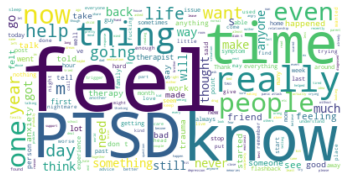

In [129]:
plt.imshow(wordcloud_ptsd, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_ptsd.to_file('/Users/radulradulov/code/rradulov/dreaddit/images/ptsd.png');

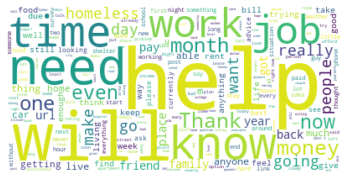

In [130]:
plt.imshow(wordcloud_ﬁnancial, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_ﬁnancial.to_file('/Users/radulradulov/code/rradulov/dreaddit/images/financial.png');

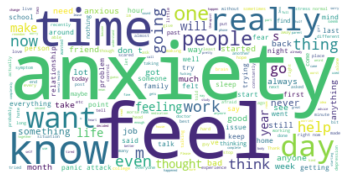

In [131]:
plt.imshow(wordcloud_anxiety , interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_anxiety.to_file('/Users/radulradulov/code/rradulov/dreaddit/images/anxiety.png');

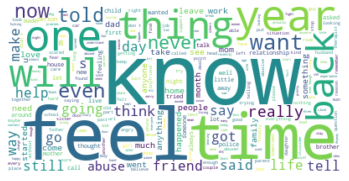

In [132]:
plt.imshow(wordcloud_abuse , interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_abuse.to_file('/Users/radulradulov/code/rradulov/dreaddit/images/abuse.png');

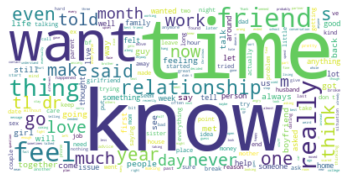

In [133]:
plt.imshow(wordcloud_social , interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_social.to_file('/Users/radulradulov/code/rradulov/dreaddit/images/social.png');

### Testing various ML models

### Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
log_model = LogisticRegression(max_iter=1_000)

In [21]:
y_pred = log_model.fit(X_train,y_train).predict(X_test)

In [22]:
log_model.score(X_test,y_test)

0.7398601398601399

In [27]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
grid_log_reg = {'penalty': ['none'], #['l1', 'l2', 'elasticnet', 'none'],
                #'C':[0, 0.0001, 0.01, 1, 10, 100, 1000],
                'solver':['newton-cg', 'newton-cg', 'lbfgs'] }  #, 'sag', 'saga']}

log_search = RandomizedSearchCV(log_model, grid_log_reg, n_jobs=-1, cv=10, verbose=0, scoring='accuracy' )
log_search.fit(X_train,y_train, sample_weight = clean_train['confidence']) 

/Users/radulradulov/.pyenv/versions/3.8.12/envs/dreaddit/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
                   n_jobs=-1,
                   param_distributions={'penalty': ['none'],
                                        'solver': ['newton-cg', 'newton-cg',
                                                   'lbfgs']},
                   scoring='accuracy')

In [28]:
log_search.best_estimator_

LogisticRegression(max_iter=1000, penalty='none', solver='newton-cg')

In [25]:
log_search.best_score_

0.7451351216841686

In [26]:
log_search.score(X_test, y_test)

0.737062937062937

In [ ]:
#Best model from the Grid Search
#LogisticRegression(C=1e-05, max_iter=1000, penalty='none', solver='newton-cg')
#0.7580419580419581

In [ ]:
# from sklearn.feature_selection import SequentialFeatureSelector
# selector = SequentialFeatureSelector(LogisticRegression(max_iter=1_000), cv=10, n_jobs=-1, direction='backward',
#                                     n_features_to_select=0.6)
# selector.fit(X_train, y_train)
# selector.transform(X_train)
# len(selector.get_feature_names_out())
# X_train_selected = pd.DataFrame(columns = selector.get_feature_names_out(),
#                                 index = X_train.index,
#                                 data = selector.transform(X_train))
# X_test_selected = X_test[selector.get_feature_names_out()]

### SVC

In [ ]:
from sklearn.svm import SVC

SVC_model = SVC()

gird_SVC = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
            'C':stats.uniform(0.01,10),
            'gamma':stats.loguniform(0.01,10)}

In [ ]:
SVC_search = RandomizedSearchCV(SVC_model, gird_SVC, n_jobs=-1, cv=10, verbose=0, scoring='accuracy')
SVC_search.fit(X_train,y_train, sample_weight = clean_train['confidence']) 

In [ ]:
SVC_search.best_estimator_

In [ ]:
SVC_search.best_score_

In [ ]:
SVC_search.score(X_test, y_test)

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_model = KNeighborsClassifier()
grid_knn = {'n_neighbors':[2,3,4,5,6,7,8,9,10,12,15,20,25]}

In [ ]:
knn_search =  RandomizedSearchCV(knn_model, grid_knn, cv=10, scoring='accuracy', verbose=1 )

In [ ]:
knn_search.fit(X_train,y_train) 

In [ ]:
knn_search.best_estimator_

In [ ]:
knn_search.best_score_

In [ ]:
knn_search.score(X_test, y_test)

### XGBoost

In [ ]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier(use_label_encoder=False) #eval_metric='error')

In [ ]:
grid_xgboost = {'n_estimators':range(10,300,10) ,
                'max_depth':[2,4,6,8,10,12,14,16,18,20],
                'learning_rate': stats.loguniform(0.01,0.5),
                'booster':['gbtree', 'gblinear', 'dart']
               }

search_xgboost = RandomizedSearchCV(model_xgb, grid_xgboost, cv=5,
                                    scoring='accuracy', verbose=1,n_jobs=-1)



In [ ]:
search_xgboost.fit(X_train,y_train)

In [ ]:
search_xgboost.best_score_

In [ ]:
search_xgboost.best_estimator_

In [ ]:
search_xgboost.score(X_test, y_test)

### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier  #,GradientBoostingClassifier
ada_model = AdaBoostClassifier() #searching of the best estimator

In [ ]:
gird_ada = {'base_estimator':[LogisticRegression(C=1000, max_iter=1000, penalty='none', solver='newton-cg')],  # GradientBoostingClassifier()],
            'learning_rate': stats.loguniform(0.01,0.5)}

In [ ]:
search_ada = RandomizedSearchCV(ada_model, gird_ada, cv=10, scoring='accuracy', verbose=0 )

In [ ]:
search_ada.fit(X_train, y_train)

In [ ]:
search_ada.best_score_

In [ ]:
search_ada.best_estimator_

In [ ]:
search_ada.score(X_test, y_test)

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()


In [ ]:
gird_gb = {'n_estimators':range(10,300,10),
           'learning_rate': stats.loguniform(0.01,0.5)}

In [ ]:
search_gb = RandomizedSearchCV(gb_model, gird_gb, cv=10, scoring='accuracy', verbose=1, n_jobs=-1, refit=True )

In [ ]:
search_gb.fit(X_train, y_train)

In [ ]:
search_gb.best_score_

In [ ]:
search_gb.best_estimator_

In [ ]:
search_gb.score(X_test, y_test)

### Stacking Classifiers

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

ensamble = StackingClassifier( 
    estimators=[('log_reg',log_search.best_estimator_), 
                ('svc', SVC_search.best_estimator_), 
                ('gb', search_gb.best_estimator_)], n_jobs=-1)
    

In [ ]:
from sklearn.model_selection import cross_val_score
ensamble_score = cross_val_score(ensamble, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)

In [ ]:
ensamble_score.mean()

In [ ]:
ensamble.fit(X_train, y_train)

In [ ]:
ensamble.score(X_test, y_test)

In [ ]:
from sklearn.ensemble import BaggingClassifier

weak_learner = LogisticRegression() #log_search.best_estimator_
bagged_model = BaggingClassifier(weak_learner, n_estimators=30, verbose=0)

bagged_model.fit(X_train, y_train)
bagged_model.score(X_test, y_test)